# Прототипирование тестового задания на тему "Компьютерное Зрение"      
 ## Выполнил: Адаменко Даниил Дмитриевич
## [ссылка на GitHub](https://github.com/Adam14b/EmotionalRecognition-ImageGenerator)

# Создание и обучение модели "МКЭ"

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## работа с данными:
- [ссылка на данные](https://www.kaggle.com/datasets/msambare/fer2013)

In [ ]:
# параметры
img_width, img_height = 48, 48
batch_size = 64

In [ ]:
# Пути к данным
train_data_dir = r"C:\Users\Adam\Test_Task\data\test"
test_data_dir = r"C:\Users\Adam\Test_Task\data\train"

In [ ]:
# создание генераторов данных
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

## Создание модели:

In [ ]:
# создание сверточной модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # три категории эмоций
])

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['f1_score', 'precision','recall']) # такие метрики были выбраны из-за дисбаланса в классах

## Обучение и сохранение модели
в будущем нужно будет добавить ```early_stopping``` и ```checkpoints```. Сейчас модель дает достаточно высокий F1-score на тестовой выборке, но есть небольшое переобучение. В нынешней версии tensorflow наблюдаются проблемы с созданием ```early_stopping``` и ```checkpoints```, основывающихся на метрике 'F1_val'.

In [ ]:
# обучение модели
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=test_generator.samples // batch_size,
    epochs=50
)

In [ ]:
# сохранение модели
model.save(r'C:\Users\Adam\Test_Task\model.keras')

# Применение модели:

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd

In [ ]:
# Загрузка обученной модели
try:
    model = tf.keras.models.load_model('/Users/daniiladamenko/Downloads/model.keras')
    print("Модель успешно загружена.")
except Exception as e:
    print(f"Ошибка при загрузке модели: {e}")

In [ ]:
# Захват видео
cap = cv2.VideoCapture(1)  # 0 для первой камеры ######################################
if not cap.isOpened():
    print("Не удалось получить доступ к камере.")
    exit()

In [ ]:
emotion_labels = {0: 'Negative', 2: 'Positive', 1: 'Neutral'}  # "лейблы классов"

In [ ]:
# запуск модели
NegativeAmount = 0
PositiveAmount = 0
NeutralAmount = 0
while True:
    ret, frame = cap.read()
    if not ret:
        print("Не удалось получить кадр.")
        break

    # Предварительная обработка кадра
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))
        face = face / 255.0
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)

        # Предсказание эмоции
        try:
            prediction = model.predict(face, verbose= 0)
            emotion = np.argmax(prediction)
            label = emotion_labels[emotion]
        except Exception as e:
            print(f"Ошибка при предсказании: {e}")
            continue
        #инкрементирование переменных, отвечающих за количество эмоций
        if (label == 'Negative'): NegativeAmount += 1
        if (label == 'Positive'): PositiveAmount += 1
        if (label == 'Neutral'): NeutralAmount += 1
        cv2.putText(frame,f'удовлетворенность :{round(((0.5*NeutralAmount + PositiveAmount)/(0.5*NeutralAmount + PositiveAmount + NegativeAmount) * 100))}%', (10,60), cv2.FONT_HERSHEY_COMPLEX, 0.9,(255, 255, 0), 2)
        color = (0, 255, 0) if label == 'Positive' else (0, 0, 255) if label == 'Negative' else (255, 255, 0)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    # Показ видео
    cv2.imshow('Video', frame)
    # остановка в случае нажатия на "Q"
    if cv2.waitKey(1) & 0xFF in [ord('q') ]: #можно добавить или изменить клавиши закрытия программы
        break
#вывод таблицы итогов
output = pd.DataFrame.from_dict({'Общая удовлетворенность':[f'{round(((0.5*NeutralAmount + PositiveAmount)/(0.5*NeutralAmount + PositiveAmount + NegativeAmount) * 100))} %'],
    'Негативные эмоции' :[f'{((100 - ((NeutralAmount + PositiveAmount)/(NeutralAmount + PositiveAmount + NegativeAmount) * 100)))} %'],
    'Нейтральне эмоции': [f'{round(((NeutralAmount)/(NeutralAmount + PositiveAmount + NegativeAmount) * 100),4)} %'],
    'Положительные эмоции': [f'{round((PositiveAmount/(NeutralAmount+PositiveAmount+NegativeAmount)*100),4)} %']
    }).T
output.columns = ['Результаты звонка:']
# вывод, очистка памяти, выход
display(output)
cap.release()
cv2.destroyAllWindows()

# Пример ```МГПИ```
используется предобученная модель stable diffusion, запущенная локально

## Установка и настройка модели

In [1]:
!pip install transformers
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.9 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# Загрузка Stable Diffusion
model_id = "stabilityai/stable-diffusion-2"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
def generate_forest_image(heights):
    prompt = (f'{len(heights)} realistic trees in a row.  Heights of trees must have same proportionals as this array {heights}' #не понимает русские промты
    )
    # Генерация изображения
    image = pipe(prompt, height=512, width=1024).images[0]
    return image

## Пример использования модели с универасальным промтом

  0%|          | 0/50 [00:00<?, ?it/s]

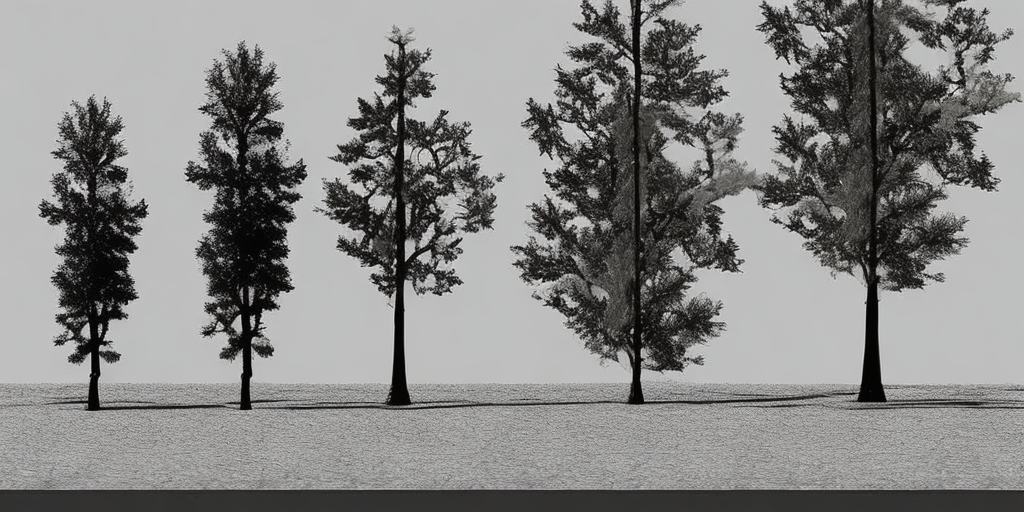

In [11]:
heights = [10, 15, 20, 30, 40] # вводим уровень доходности акций
generate_forest_image(heights)